In [25]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, AffinityPropagation, SpectralClustering, OPTICS
from sklearn import metrics
from IPython.display import clear_output

warnings.filterwarnings("ignore")

In [26]:
db = pd.read_csv('hm9.csv', index_col='item_id')

# droping outliers
db.drop(list(db[db['price_usd'] > 220000].index) + list(db[db['price_usd'] < 5000].index), inplace = True)

X_1 = db.drop(columns = 'price_usd')
Y_1 = db['price_usd']

In [27]:
def load_data(X_train, X_test, y_train, y_test, device):

    return torch.tensor(X_train.values, dtype=torch.float32, device=device), \
           torch.tensor(X_test.values, dtype=torch.float32, device=device), \
           torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32, device=device), \
           torch.tensor(y_test.values.reshape(-1,1), dtype=torch.float32, device=device)

X_train, X_test, y_train, y_test = train_test_split(X_1, Y_1, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = load_data(X_train, X_test, y_train, y_test, 'cuda')

###        XGBoost

RMSE xgboost: 18912.228515625


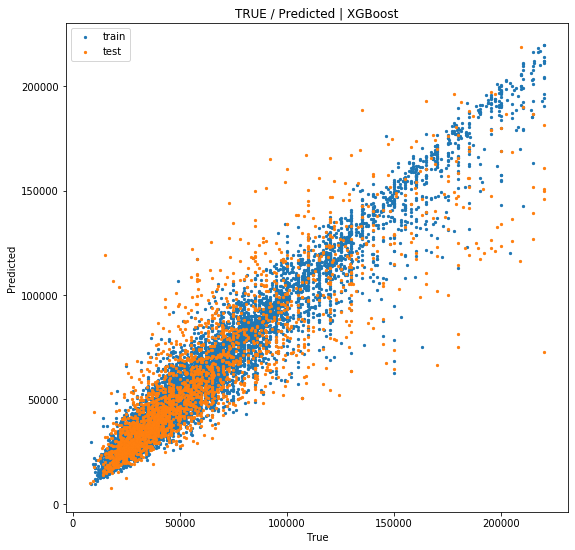

In [4]:
import xgboost as xgb

xg_model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=1000, objective='reg:squarederror' )

xg_model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())

print(f'RMSE xgboost: {np.sqrt(mse(xg_model.predict(X_test.cpu().numpy()), y_test.cpu().numpy()))}')

plt.figure(figsize=(9,9))
plt.title('TRUE / Predicted | XGBoost')
plt.legend(['train', 'test'], loc='upper left')
plt.scatter(y_train.cpu().detach().numpy(), xg_model.predict(X_train.cpu().detach().numpy()), s=5, label='train')
plt.scatter(y_test.cpu().detach().numpy(), xg_model.predict(X_test.cpu().detach().numpy()), s=5, label='test')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()

plt.show()

###        NN

4000 / 4000
RMSE NN: 19414.869140625


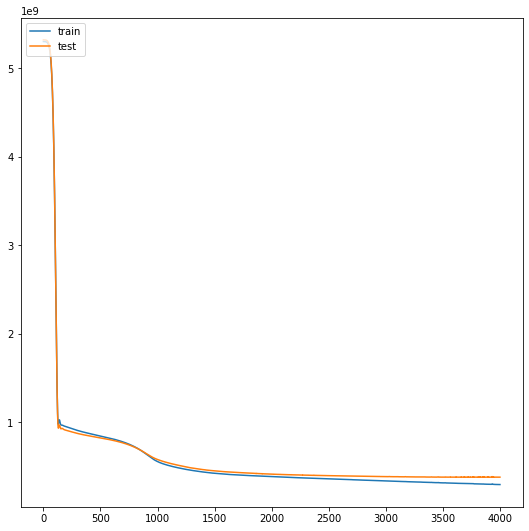

In [127]:
class TwoLayer(torch.nn.Module):
    def __init__(self, d_in, h1, h2, h3, h4, h5, d_out):
        super(TwoLayer, self).__init__()
        self.linear1 = torch.nn.Linear(d_in, h1)
        self.linear2 = torch.nn.Linear(h1, h2)
        self.linear3 = torch.nn.Linear(h2, h3)
        self.linear4 = torch.nn.Linear(h3, h4)
        self.linear5 = torch.nn.Linear(h4, h5)
        self.linear6 = torch.nn.Linear(h5, d_out)

    def forward(self, x):
        h1_relu = self.linear1(x).clamp(min=0)
        h2_relu = self.linear2(h1_relu).clamp(min=0)
        h3_relu = self.linear3(h2_relu).clamp(min=0)
        h4_relu = self.linear4(h3_relu).clamp(min=0)
        h5_relu = self.linear5(h4_relu).clamp(min=0)
        y_pred = self.linear6(h5_relu)
        return y_pred

train_losses=[]
test_losses=[]

d_in = 45
h1, h2, h3, h4, h5 = 2000, 1000, 500, 250, 100
d_out = 1

nn_model = TwoLayer(d_in, h1, h2, h3, h4, h5, d_out)
nn_model.cuda()

criterion = torch.nn.MSELoss()
msee = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-4)
for t in range(4000):
    y_pred = nn_model(X_train)
    loss = criterion(y_pred, y_train)
    
    train_losses.append(loss.cpu().detach().numpy())
    test_losses.append(msee(nn_model(X_test), y_test).cpu().detach().numpy())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (t+1) % 50 == 0:
        clear_output()
        print(f'{t+1} / {4000}')
    
print(f'RMSE NN: {torch.sqrt(torch.nn.MSELoss()(nn_model(X_test), y_test))}')
plt.figure(figsize=(9,9))
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'], loc='upper left')

plt.show()

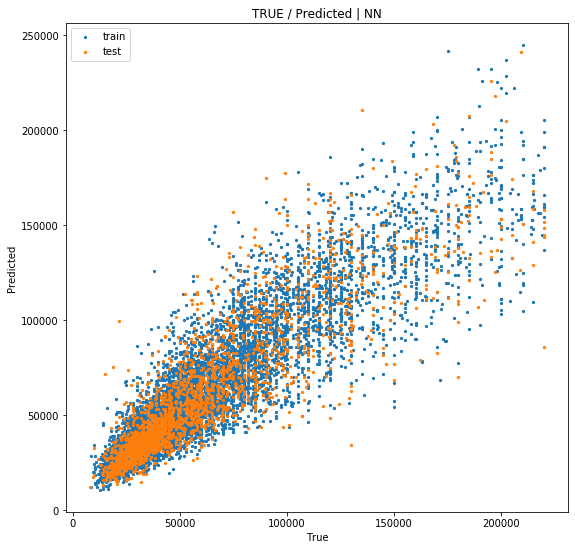

In [128]:
plt.figure(figsize=(9,9))
plt.title('TRUE / Predicted | NN')
plt.legend(['train', 'test'], loc='upper left')
plt.scatter(y_train.cpu().detach().numpy(), nn_model(X_train).cpu().detach().numpy(), s=5, label='train')
plt.scatter(y_test.cpu().detach().numpy(), nn_model(X_test).cpu().detach().numpy(), s=5, label='test')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()

plt.show()

###### assembling

In [129]:
xg_pred = xg_model.predict(X_test.cpu().numpy())
nn_pred = nn_model(X_test).cpu().detach().numpy().reshape(-1, )

new_pred = (xg_pred + nn_pred) / 2

print(f'RMSE NN + xgboost: {np.sqrt(mse(new_pred, y_test.cpu().numpy()))}')

RMSE NN + xgboost: 18512.232421875


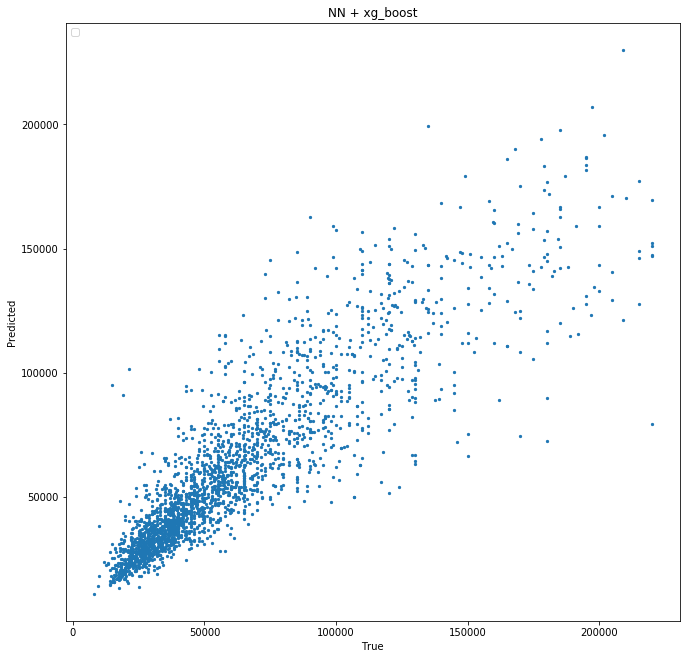

In [130]:
plt.figure(figsize=(11,11))
plt.title('NN + xg_boost')
plt.legend(['train', 'test'], loc='upper left')
plt.scatter(y_test.cpu().detach().numpy(), new_pred, s=5)
plt.xlabel('True')
plt.ylabel('Predicted')

plt.show()

###### Add embedding vector (avg of embeddings)

In [28]:
embedding_db = pd.read_csv('embedding.csv', index_col='item_id')

features_indexes = db.index
embedding_indexes = embedding_db.index

item_ids = list()
for i in features_indexes:
    if i in embedding_indexes:
        item_ids.append(i)
        
full_db = pd.concat([db.loc[item_ids], embedding_db.loc[item_ids]], axis=1)

X_2 = full_db.drop(columns = 'price_usd')
Y_2 = full_db['price_usd']

X_train, X_test, y_train, y_test = train_test_split(X_2, Y_2, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = load_data(X_train, X_test, y_train, y_test, 'cuda')

10000 / 2000
RMSE NN + embedding: 17267.115234375


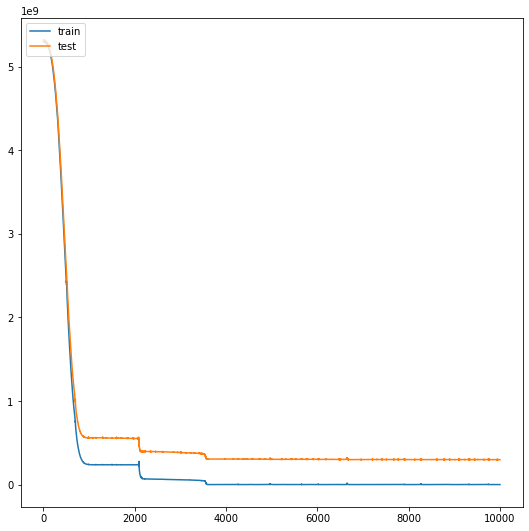

In [36]:
class TwoLayer(torch.nn.Module):
    def __init__(self, d_in, h1, h2, h3, h4, h5, d_out):
        super(TwoLayer, self).__init__()
        self.linear1 = torch.nn.Linear(d_in, h1)
        self.linear2 = torch.nn.Linear(h1, h2)
        self.linear3 = torch.nn.Linear(h2, h3)
        self.linear4 = torch.nn.Linear(h3, h4)
        self.linear5 = torch.nn.Linear(h4, h5)
        self.linear6 = torch.nn.Linear(h5, d_out)
        
        self.bn1 = torch.nn.BatchNorm1d(num_features=h1)
        self.bn2 = torch.nn.BatchNorm1d(num_features=h2)
        self.bn3 = torch.nn.BatchNorm1d(num_features=h3)
        self.bn4 = torch.nn.BatchNorm1d(num_features=h4)
    def forward(self, x):
        
        h1_relu = self.bn1(self.linear1(x)).clamp(min=0)
        h2_relu = self.bn2(self.linear2(h1_relu)).clamp(min=0)
        h3_relu = self.bn3(self.linear3(h2_relu)).clamp(min=0)
        h4_relu = self.bn4(self.linear4(h3_relu)).clamp(min=0)
        h5_relu = self.linear5(h4_relu).clamp(min=0)
        y_pred = self.linear6(h5_relu)
        return y_pred

train_losses=[]
test_losses=[]

d_in = 1045
h1, h2, h3, h4, h5 = 1000, 700, 500, 300, 100
d_out = 1

nn_model = TwoLayer(d_in, h1, h2, h3, h4, h5, d_out)
nn_model.cuda()

criterion = torch.nn.MSELoss()
msee = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
for t in range(10000):
    y_pred = nn_model(X_train)
    loss = criterion(y_pred, y_train)
    
    train_losses.append(loss.cpu().detach().numpy())
    test_losses.append(msee(nn_model(X_test), y_test).cpu().detach().numpy())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (t+1) % 50 == 0:
        clear_output()
        print(f'{t+1} / {10000}')
    
print(f'RMSE NN + embedding: {torch.sqrt(torch.nn.MSELoss()(nn_model(X_test), y_test))}')
plt.figure(figsize=(9,9))
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
17358.389

*assembling*

In [40]:
nn_pred = nn_model(X_test).cpu().detach().numpy().reshape(-1, )

new_pred = (xg_pred + nn_pred) / 2

print(f'RMSE NN + xgboost + embedding: {np.sqrt(mse(new_pred, y_test.cpu().numpy()))}')
print(f'MAE NN + xgboost + embedding: {mae(new_pred, y_test.cpu().numpy())}')

RMSE NN + xgboost + embedding: 16192.2958984375
MAE NN + xgboost + embedding: 10224.4375


In [31]:
median_model = np.array([[np.median(Y_1)] * 2425])
mean_model =   np.array([[Y_1.mean()] * 2425])
print('------baseline-----')
print(f'RMSE: {np.sqrt(mse(y_test.cpu().numpy().reshape(1,-1), mean_model))}')
print(f'MAE: {mae(y_test.cpu().numpy().reshape(1,-1), median_model)}')

------baseline-----
RMSE: 39528.78491799921
MAE: 28314.17237113402


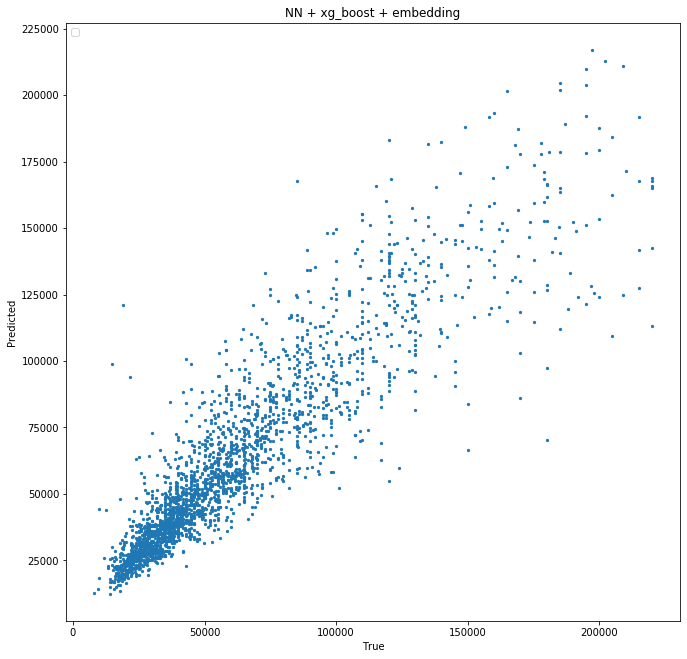

In [161]:
plt.figure(figsize=(11,11))
plt.title('NN + xg_boost + embedding')
plt.legend(['train', 'test'], loc='upper left')
plt.scatter(y_test.cpu().detach().numpy(), new_pred, s=5)
plt.xlabel('True')
plt.ylabel('Predicted')

plt.show()

P.S: I've tried many options for different NN / xgboost structures with different hyperparameters, and the models shown in this model are the best I have found